In [62]:
import yfinance as yf
import matplotlib.pyplot as plt
import pandas as pd
from datetime import datetime, timedelta

In [63]:
#define the ticker symbol
tickerSymbol = 'SPY'

In [64]:
#get data on this ticker
tickerData = yf.Ticker(tickerSymbol)

In [65]:
#get the historical prices for this ticker
tickerDf = tickerData.history(interval='1d', start='1993-3-1', end='2022-10-31')

In [66]:
priceData = tickerDf.Open

In [67]:
priceData = priceData.asfreq(pd.infer_freq(priceData.index))

In [68]:
priceData

Date
1993-03-01 00:00:00-05:00     25.694403
1993-03-02 00:00:00-05:00     25.550236
1993-03-03 00:00:00-05:00     25.946647
1993-03-04 00:00:00-05:00     26.054764
1993-03-05 00:00:00-05:00     25.910611
                                ...    
2022-10-24 00:00:00-04:00    375.890015
2022-10-25 00:00:00-04:00    378.790009
2022-10-26 00:00:00-04:00    381.619995
2022-10-27 00:00:00-04:00    383.070007
2022-10-28 00:00:00-04:00    379.869995
Freq: D, Name: Open, Length: 10834, dtype: float64

Text(0.5, 1.0, 'SPY Price Data')

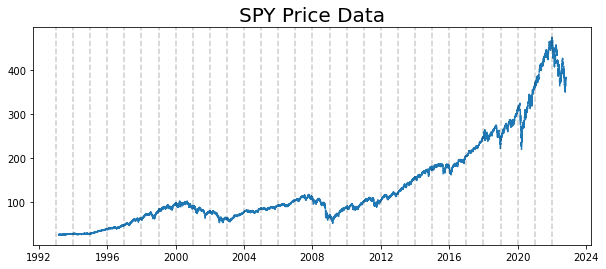

In [69]:
plt.figure(figsize=(10,4))
plt.plot(priceData)
for year in range(priceData.index[0].year, priceData.index[-1].year+1):
    plt.axvline(datetime(year,1,1), color='k', linestyle='--', alpha=0.2)
plt.title("%s Price Data"%tickerSymbol, fontsize=20)

In [70]:
#Basic Buying Protocol:
# Buy if stock increasing for  consecutive days
#Basic Selling Protocols:
# Sell if stock decreasing for  consecutive days (and we've made a profit)

In [71]:
def get_buying_selling_days(price_data, b, s):
    
    #get the percent change day after day
    pct_change = price_data.pct_change()[1:]
    
    #this function checks the buying condition
    def buying_condition(sub_series):
        return (sub_series > 0).all()
    
    #this function checks the selling condition
    def selling_condition(sub_series):
        return (sub_series < 0).all()
    
    #get all buying days in the data
    buying_days = pct_change.rolling(b).apply(buying_condition)
    
    #get all potential selling days in the data
    potential_selling_days = pct_change.rolling(s).apply(selling_condition)
    
    #return a dictionary
    return {'buying_days': buying_days, 'potential_selling_days': potential_selling_days}

In [111]:
info_dict = get_buying_selling_days(priceData, 7, 7)

In [112]:
buying_days = info_dict['buying_days']
potential_selling_days = info_dict['potential_selling_days']

In [108]:
#create dataframe to store information
df_stocks = pd.DataFrame(index = buying_days.index)

In [109]:
#populate df with buying days, possible selling days, and price
df_stocks['buying_day'] = (buying_days == 1)
df_stocks['potential_selling_day'] = (potential_selling_days == 1)
df_stocks['price'] = priceData

#only keep days that are buying or possible selling days
df_stocks = df_stocks[(df_stocks.buying_day | df_stocks.potential_selling_day)]

In [110]:
df_stocks.head()

,buying_day,potential_selling_day,price
Date,,,


In [99]:
def check_cumulative_percent_change(price_data, buy_date, potential_sell_date):
    """
    This helper function will check if the cumulative percent change
    between a buying and potential selling day yields overall growth
    """
    
    #get the percent change day after day
    pct_change = price_data.pct_change()[1:]
    
    sub_series = 1 + pct_change[buy_date + timedelta(hours=1): potential_sell_date]

    return sub_series.product() > 1

In [100]:
def get_investing_result(df_stocks, starting_funds, verbose=False):
    
    #get a copy of price data
    price_data = df_stocks.price
    
    #at start, not holding any shares
    holding = False
    
    #init vars
    current_funds = starting_funds
    current_shares = 0
    last_buy_date = None
    
    #init dict of buying and selling dates
    events_list = []
    
    #for each buying day and potential selling day...
    for date,data in df_stocks.iterrows():
        
        #if not currently holding shares, and this is a buying day...
        if (not holding) and data.buying_day:
            
            #calculate the number of shares we can buy
            num_shares_to_buy = int(current_funds / data.price)
            
            #update number of shares
            current_shares += num_shares_to_buy
            
            #decrease current funds
            current_funds -= num_shares_to_buy * data.price
            
            #set last buy date
            last_buy_date = date
            events_list.append(('b', date))
            
            #we are now holding shares
            holding = True
            
            if verbose:
                print('Bought %s shares at $%s on %s totaling $%s'%(num_shares_to_buy, data.price, date.date(), round(num_shares_to_buy*data.price,2)))
        
        #if you are holding shares, and this is a potential selling day...
        elif holding and data.potential_selling_day:
            
            #check to make sure we're making a profit
            if check_cumulative_percent_change(price_data, last_buy_date, date):
                #add to our current funds
                current_funds += current_shares * data.price
                
                if verbose:
                    print('Sold %s shares at $%s on %s totaling $%s'%(current_shares, data.price, date.date(), round(num_shares_to_buy*data.price,2)))
                    print('--------------------------------------')
                    
                #reset current shares
                current_shares = 0
                
                #we are no longer holding shares
                holding = False
                
                events_list.append(('s', date))
                
    #get the stock price at the end of the time span
    final_stock_price = price_data[-1]
        
    #get the final total value of all assets (funds + stock value)
    final_value = current_funds + final_stock_price * current_shares
    
    #return the percent change in value
    return round((final_value - starting_funds) / starting_funds,2), events_list

In [101]:
percent_change, events_list = get_investing_result(df_stocks, 10000, True)

In [102]:
print(percent_change)

0.0


(23.0, 497.0)

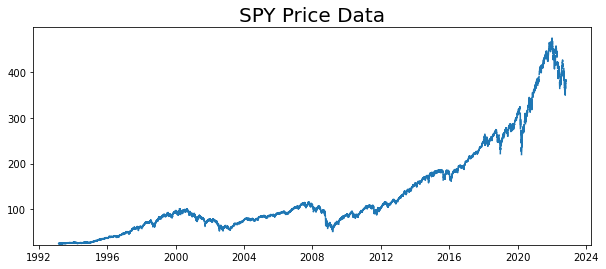

In [103]:
plt.figure(figsize=(10,4))
plt.plot(priceData)

y_lims = (int(priceData.min()*.95), int(priceData.max()*1.05))
shaded_y_lims = int(priceData.min()*.5), int(priceData.max()*1.5)

for idx, event in enumerate(events_list):
    color = 'red' if event[0] == 'b' else 'blue'
    plt.axvline(event[1], color=color, linestyle='--', alpha=0.4)
    if event[0] == 's':
        plt.fill_betweenx(range(*shaded_y_lims), 
                          event[1], events_list[idx-1][1], color='k', alpha=0.1)

plt.title("%s Price Data"%tickerSymbol, fontsize=20)
plt.ylim(*y_lims)